# CODICE BUONO

# ***Missing and spurious interactions and the reconstruction of complex networks***

| Nome              |  Matricola |
|-------------------|----------|
| Eugenia Boccanera | 2109310  | 
| Lucrezia Rossi    | 2122164  |


In [119]:
import numpy as np 
import random 
import matplotlib.pyplot as plt 
import networkx as nx
import math
from itertools import combinations

## 1 Initialize the Network

### 1.1 Network Generation and Modification

First we define functions for generating and modifying networks using the Stochastic Block Model (SBM). The *generate_block_network* function creates a graph where nodes belong to predefined blocks, with edge connections determined by a probability matrix. The *modify_network* function alters an existing graph by randomly removing and adding edges, allowing for controlled network modifications. Additionally, *get_adjacency_matrix* converts the graph into an adjacency matrix for numerical analysis.

In [120]:
# Function to create a simple block network  NEW
def generate_block_network(block_sizes, prob_matrix):
    """
    Generates a network based on a stochastic block model (SBM).
    
    :param block_sizes: List specifying the number of nodes in each block.
    :param prob_matrix: Square NxN matrix with connection probabilities between blocks.
    :return: A NetworkX Graph object.
    """
    num_blocks = len(block_sizes)
    G = nx.Graph()
    
    # Creating nodes with block labels
    node_labels = []
    current_label = 0
    for i, size in enumerate(block_sizes):
        for _ in range(size):
            G.add_node(current_label, block=i)
            node_labels.append(current_label)
            current_label += 1
    
    # Adding edges based on probability in the adjacency matrix
    start_idx = 0
    for i in range(num_blocks):
        end_idx = start_idx + block_sizes[i]
        start_jdx = 0
        for j in range(num_blocks):
            end_jdx = start_jdx + block_sizes[j]
            
            for u in range(start_idx, end_idx):
                for v in range(start_jdx, end_jdx):
                    if u < v and np.random.rand() < prob_matrix[i][j]:
                        G.add_edge(u, v)
            
            start_jdx = end_jdx
        start_idx = end_idx
    
    return G



def get_adjacency_matrix(G):        
    """Computes the adjacency matrix of the network G."""
    return nx.to_numpy_array(G)


def modify_network(G, modification_fraction):
    """
    Randomly removes and adds a fraction of edges in the network G.
    
    :param G: The input graph (NetworkX object).
    :param modification_fraction: Fraction of edges to modify.
    :return: Modified graph, list of removed edges, list of added edges.
    """
    G_modified = G.copy()
    edges = list(G.edges())
    nodes = list(G.nodes())
    num_to_modify = int(len(edges) * modification_fraction)
    
    removed_edges = []
    added_edges = []
    
    # Randomly remove edges
    edges_to_remove = np.random.choice(len(edges), num_to_modify // 2, replace=False)
    for idx in edges_to_remove:
        removed_edges.append(edges[idx])
        G_modified.remove_edge(*edges[idx])
    
    # Randomly add edges
    for _ in range(num_to_modify // 2):
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G_modified.has_edge(u, v):
            G_modified.add_edge(u, v)
            added_edges.append((u, v))
    
    return G_modified, removed_edges, added_edges


#def plot_modified_network(G, removed_edges, added_edges, title):    C'ERA QUESTO QUI
   

Then we group all the functions responsible for visualizing network structures. These functions generate plots to represent graphs and highlight modifications.

In [121]:
##### PLOTS 
def plot_true_graph(G):
    """
    Plots the given graph with node colors based on their block assignment.

    :param G: NetworkX graph object.
    """
    pos = nx.spring_layout(G)  # Compute node positions
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, 
            node_color=[G.nodes[n]['block'] for n in G.nodes()], 
            edge_color='black')
    plt.title("True Graph")
    plt.show()
    

def plot_modified_network(G, removed_edges, added_edges, title):
    """Plots the observed network with highlighted removals and additions."""
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')  # node_color=[G.nodes[n]['block'] for n in G.nodes()])
    nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color='red', style='dashed', width=2)
    nx.draw_networkx_edges(G, pos, edgelist=added_edges, edge_color='green', style='solid', width=2)
    plt.title(title)
    plt.show()
    

def plot_H_trace(H_burn_in, H_full_trace):
    """
    Plots the full trace of H(P), including the burn-in phase and sampling.

    :param H_burn_in: List of H(P) values during the burn-in phase.
    :param H_full_trace: List of H(P) values during the full MCMC sampling.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(H_burn_in)), H_burn_in, marker=',', linestyle='-', linewidth=0.7, label="Burn-in")
    plt.plot(range(len(H_burn_in), len(H_burn_in) + len(H_full_trace)), H_full_trace, marker=',', linestyle='-', linewidth=0.7, label="Sampling")
    plt.axvline(x=len(H_burn_in), color='r', linestyle='--', linewidth=1, label="End of burn-in")
    plt.xlabel("Iterations")
    plt.ylabel("H(P)")
    plt.title("Full Trace of H(P) Without Thinning")
    plt.legend()
    plt.show()


def plot_final_H_trace(H_final, thinning_interval):
    """
    Plots the final trace of H(P) after applying thinning.

    :param H_final: List of H(P) values after thinning.
    :param thinning_interval: Interval used for thinning.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(H_final)), H_final, marker='o', linestyle='-')
    plt.xlabel(f'Sampling iterations with thinning every {thinning_interval}')
    plt.ylabel('H(P)')
    plt.title('Final Trace of H(P) After Thinning')
    plt.show()


def plot_interaction_accuracies(error_fractions, accuracy_missing, accuracy_spurious):
    """
    Plots the accuracy for Missing and Spurious Interactions.

    :param error_fractions: List of error fractions.
    :param accuracy_missing: Accuracy values for missing interactions.
    :param accuracy_spurious: Accuracy values for spurious interactions.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot for Missing Interactions
    ax1.plot(error_fractions, accuracy_missing, 'ko-', markersize=8, label='Missing interactions')
    ax1.set_xlabel('Fraction of removed links (f)')
    ax1.set_ylabel('Accuracy (probability)')
    ax1.set_title('Missing Interactions')
    ax1.legend()
    ax1.grid(True)

    # Plot for Spurious Interactions
    ax2.plot(error_fractions, accuracy_spurious, 'ko-', markersize=8, label='Spurious interactions')
    ax2.set_xlabel('Fraction of added links (f)')
    ax2.set_ylabel('Accuracy (probability)')
    ax2.set_title('Spurious Interactions')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


### 1.2 Computing Entropy in Network Partitions

In [ ]:
def initialize_partition(G):
    """Initialize random partitions (each node is its own group)."""
    num_nodes = len(G.nodes())
    return {node: random.choice(range(num_nodes)) for node in G.nodes()}  # Randomly assign each node to a group
    #return {node: node for node in G.nodes()}  # Do not use this

def calculate_H(P, G):
    """Calculates H(P) for a given partition P and graph G."""
    # Group nodes by block
    block_nodes = {}
    for node, group in P.items():
        block_nodes.setdefault(group, []).append(node)

    lO = {}  # Observed links between blocks
    r = {}   # Possible links between blocks
    
    # Count links in the observed network
    for u, v in G.edges():
        gu, gv = P[u], P[v]
        key = tuple(sorted([gu, gv]))
        lO[key] = lO.get(key, 0) + 1
    
    # Compute rαβ (maximum possible links between groups)
    groups = list(block_nodes.keys())
    for g in groups:
        n = len(block_nodes[g])
        r[(g, g)] = n * (n - 1) // 2  # Combinations of 2
    # Pairs of different groups
    for g1, g2 in combinations(groups, 2):
        r[tuple(sorted([g1, g2]))] = len(block_nodes[g1]) * len(block_nodes[g2])
    
    # Compute H(P)
    H = 0.0
    for key in r:
        # Note: We add 1 to the denominator as per the formula and use log(comb) for the combinatorial term.
        H += math.log(r[key] + 1)
        # To avoid log(0) or errors, we use 0 if no observed links exist
        links = lO.get(key, 0)
        try:
            comb_value = math.comb(r[key], links) if r[key] >= links else 1
        except ValueError:
            comb_value = 1
        # For safety, if comb_value results in 0, we add a small epsilon
        H += math.log(comb_value + 1e-10)
    
    return H


<span style="color: yellow;">***sistemare il testo**</span> 

La funzione **calculate_H(P, G)** suddivide i passaggi in due fasi principali:

Conteggio dei collegamenti osservati (lO) e dei possibili collegamenti (r):

    Per ciascuna coppia di blocchi (identificata tramite la chiave ordinata (gu, gv) proveniente dalla partizione P) il codice conta il numero di archi osservati tra tali blocchi.

    Per ciascun blocco, nel caso intra-blocco, viene calcolato il numero massimo di possibili collegamenti r=n×(n−1)/2r = n \times (n-1)/2; mentre per coppie di blocchi distinti viene usato il prodotto delle dimensioni dei blocchi (cioè, r=∣Ba∣×∣Bb∣r = |B_a| \times |B_b|).

Composizione di H(P) come somma di due termini per ciascuna coppia di blocchi: Per ogni chiave (cioè per ogni coppia di gruppi (a,b)(a,b)) il codice fa:

    Aggiunge log⁡(rab+1)\log(r_{ab}+1) (usando math.log1p(r[key])).

    Calcola il termine combinatorio:

        Se rab≥labr_{ab} \ge l_{ab} (che dovrebbe essere sempre il caso nei grafi corretti) allora si calcola

comb_value=(rablab)\text{comb\_value} = \binom{r_{ab}}{l_{ab}}

    Successivamente viene aggiunto log⁡((rablab))\log\big(\binom{r_{ab}}{l_{ab}}\big) (ottenuto tramite math.log1p(comb_value - 1), dal momento che log1p(x) restituisce ln⁡(1+x)\ln(1+x) e quindi per x=comb_value−1x = \text{comb\_value} - 1 si ha ln⁡(comb_value)\ln(\text{comb\_value})).

Quindi, il codice accumula:
H(P)=∑(a,b)[ln⁡(rab+1)+ln⁡(rablab)]H(P) = \sum_{(a,b)} \left[ \ln\big(r_{ab}+1\big) + \ln\binom{r_{a

<span style="color: red;">***Uso di math.comb: È una scelta naturale per calcolare il coefficiente combinatorio, anche se per grafi di grandi dimensioni occorrerebbe eventualmente considerare l’uso di funzioni in log (ad es. tramite funzioni gamma o log-fattoriali) per evitare possibili overflow numerici.**</span>  

se le dimensioni del problema dovessero crescere notevolmente, potrebbe essere utile passare a una versione che calcola il logaritmo del coefficiente combinatorio in maniera più robusta (ad esempio, utilizzando funzioni log-gamma per evitare overflow).

### 1.3 MCMC Sampling for Network Partitions

This section introduces the Metropolis-Hastings MCMC algorithm to sample partitions of a given network. The function mcmc_trace_H performs the Markov Chain Monte Carlo (MCMC) sampling, first running a burn-in phase to reach equilibrium, then collecting partition samples without thinning. The acceptance criterion follows the Metropolis rule, ensuring that state transitions favor lower entropy configurations while allowing occasional increases for exploration. The output includes all recorded entropy values, enabling further analysis of the sampling process.

In [123]:
def metropolis_acceptance(delta_H):
    """Decides whether to accept a new state based on the Metropolis criterion."""
    return delta_H <= 0 or np.random.rand() < np.exp(-delta_H)


def mcmc_trace_H(G, equilibration=700, num_samples=50000):
    """
    Performs MCMC sampling, collecting all H(P) values without thinning.

    :param G: NetworkX graph for sampling.
    :param equilibration: Number of burn-in iterations.
    :param num_samples: Total number of sampling iterations.
    :return: List of sampled partitions, H values during sampling, and full trace of H values.
    """
    num_nodes = len(G.nodes())
    P = initialize_partition(G)
    
    # Store H(P) values during burn-in
    H_burn_in = []
    for i in range(equilibration):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        old_H = calculate_H(P, G)
        new_group = random.choice(range(num_nodes))
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if not metropolis_acceptance(delta_H):
            P[node] = old_group
        H_burn_in.append(calculate_H(P, G))  # Store all H(P) values in burn-in
    
    # Sampling phase without thinning
    partitions = []
    H_full_trace = []  # Stores all H(P) values during sampling without thinning
    for i in range(num_samples):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        old_H = calculate_H(P, G)
        new_group = random.choice(range(num_nodes))
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if not metropolis_acceptance(delta_H):
            P[node] = old_group
        partitions.append(P.copy())
        H_full_trace.append(calculate_H(P, G))  # Records all H(P) values without thinning
    
    return partitions, H_burn_in, H_full_trace





The following functions estimate autocorrelation in time series data. The *autocorrelation* function calculates the correlation coefficient for a given lag, helping to measure dependence between successive values. The *estimate_autocorrelation_time* function computes the integrated autocorrelation time $\tau_{\text{int}}$, which is crucial in determining how many iterations are needed for statistically independent samples in MCMC sampling. This value is used to optimize thinning in Markov Chain Monte Carlo methods.

In [124]:
def autocorrelation(series, lag):
    """
    Computes the autocorrelation coefficient for a given time series and a specific lag.
    """
    n = len(series)
    if lag >= n:
        return 0
    series = np.array(series)
    mean = np.mean(series)
    c0 = np.sum((series - mean) ** 2) / n
    ct = np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)
    return ct / c0


def estimate_autocorrelation_time(series, max_lag=None, threshold=0.05):
    """
    Estimates the integrated autocorrelation time (tau_int) of the series.

    :param series: Time series (list or array) of sampled values (e.g., H(P)).
    :param max_lag: Maximum lag for computing autocorrelation. If None, defaults to len(series) // 2.
    :param threshold: Threshold to stop summation when autocorrelation falls below this value.
    :return: tau_int, the integrated autocorrelation time.
    """
    n = len(series)
    if max_lag is None:
        max_lag = n // 2

    tau_int = 1.0  # Includes t=0, where rho(0) = 1
    acfs = [1.0]  # Autocorrelation at lag 0 is always 1
    for lag in range(1, max_lag):
        rho = autocorrelation(series, lag)
        acfs.append(rho)
        # Stop summation if autocorrelation falls below the threshold
        if rho < threshold:
            break
    # Summing terms (multiplied by 2, as per standard formula)
    tau_int += 2 * np.sum(acfs[1:])
    return tau_int, acfs


Fase di burn-in: La lista H_burn_in raccoglie il valore di H(P) ad ogni iterazione mentre esegui il burn-in. Alla fine del ciclo, con plt.plot vengono tracciati questi valori per verificare che la variabile si stabilizzi (ossia, che le fluttuazioni diventino contenute).



Il valore di soglia che hai scelto (0.05) aiuta a determinare il punto in cui la dipendenza tra i valori diventa trascurabile. Dal grafico, sembra che la correlazione svanisca abbastanza rapidamente, il che è positivo perché significa che la serie esplora lo spazio delle configurazioni in modo efficace.

Il thinning interval calcolato si basa su τint, il tempo integrato di autocorrelazione, e ci indica ogni quanto è conveniente campionare i valori per ottenere dati meno correlati e più indipendenti

.

Now we initialize a block-structured network using predefined block sizes and a probability matrix, which dictates the likelihood of connections between groups.

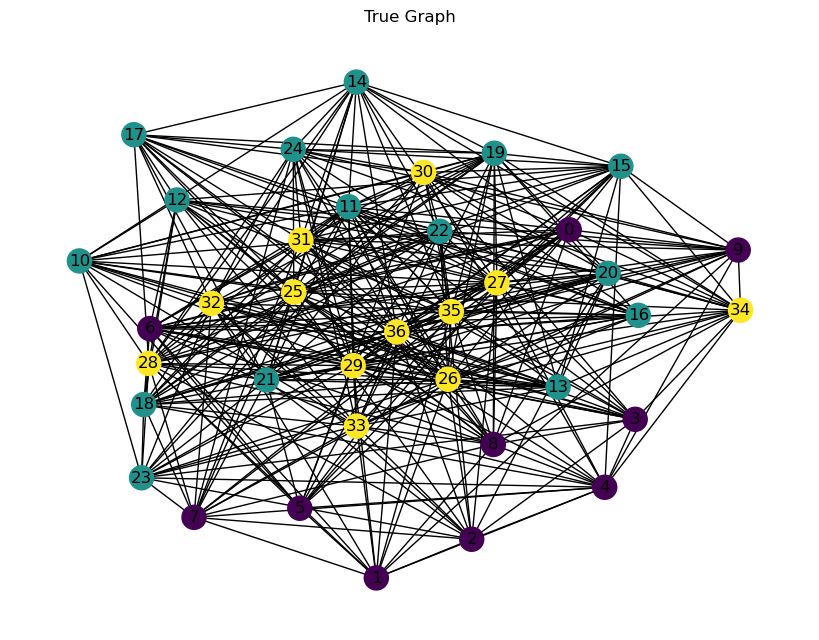

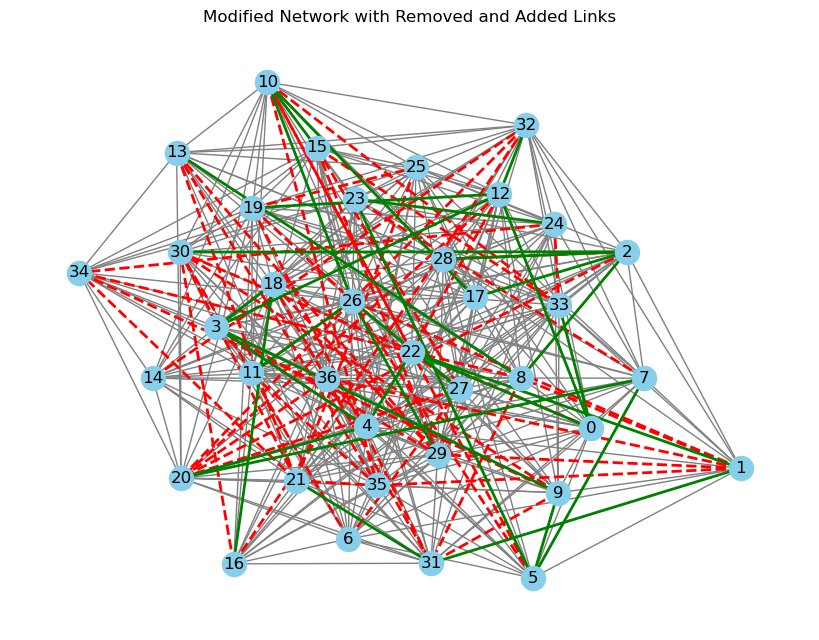

In [125]:
# Create a network using a simple block model
block_sizes = [10, 15, 12]
prob_matrix = [[0.6, 0.2, 0.7],
               [0.2, 0.5, 0.8],
               [0.1, 0.8, 0.3]]

# Generate the "true" graph using the block model
G_true = generate_block_network(block_sizes, prob_matrix)

# Plot the true graph
plot_true_graph(G_true)



# Create an observed network by randomly modifying the true graph
modification_fraction = 0.3  # For example, modify 30% of the connections
G_obs, removed_edges, added_edges = modify_network(G_true, modification_fraction)

# Plot the observed network with highlighted modifications
plot_modified_network(G_obs, removed_edges, added_edges, title="Modified Network with Removed and Added Links")


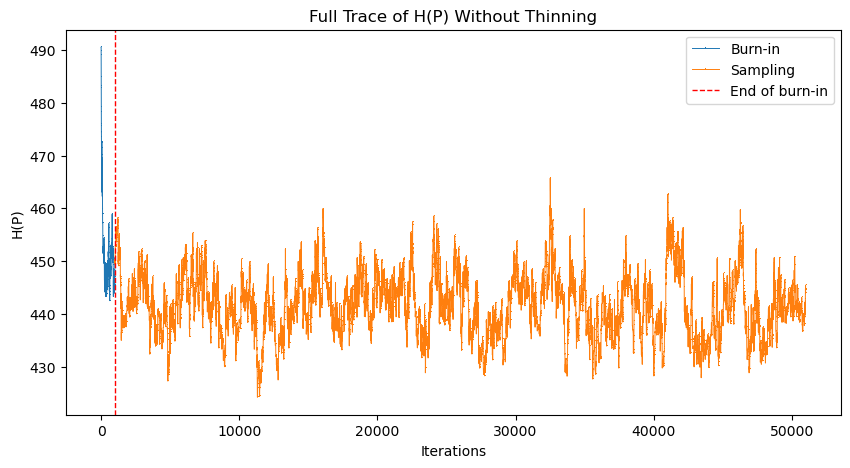

Integrated Autocorrelation Time (tau_int): 159.94
Recommended thinning every 160 iterations.


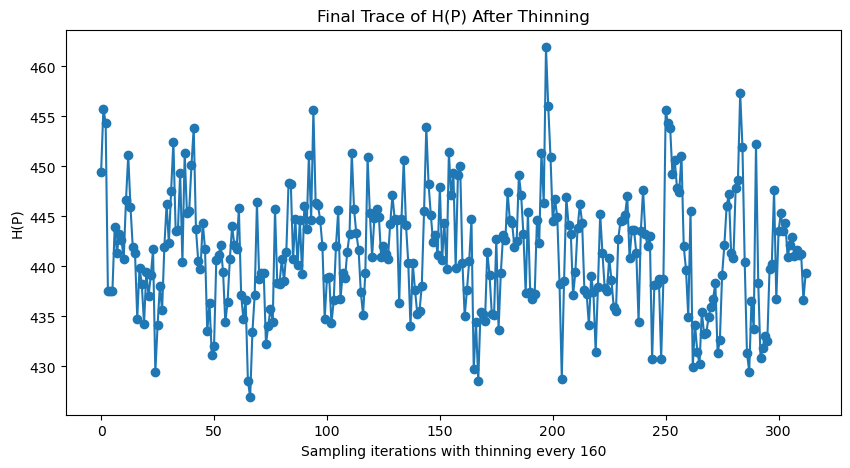

In [126]:
# Perform MCMC sampling on the observed network partitions, collecting the trace of H(P)
partitions, H_burn_in, H_full_trace = mcmc_trace_H(G_obs, equilibration=1000, num_samples=50000)

# Plot the H(P) trace
plot_H_trace(H_burn_in, H_full_trace)

# Compute the integrated autocorrelation time
tau_int, acfs = estimate_autocorrelation_time(H_full_trace, max_lag=100, threshold=0.05)
print(f"Integrated Autocorrelation Time (tau_int): {tau_int:.2f}")

# Choose thinning based on tau_int
thinning_interval = math.ceil(tau_int)
print(f"Recommended thinning every {thinning_interval} iterations.")



# Apply thinning to H(P) samples
H_final = H_full_trace[::thinning_interval]
# Apply thinning to partitions to obtain independent samples
partitions_thinned = partitions[::thinning_interval]

# Call the function to plot the final trace of H(P)
plot_final_H_trace(H_final, thinning_interval)

Fase di campionamento: Durante il ciclo di campionamento, ogni volta che i % thinning == 0 viene conservato il campione della partizione (con P.copy()) e il corrispondente valore di H(P) in H_samples. Anche qui il plot aiuta a visualizzare l’andamento e a valutare se i campioni raccolti siano, a grandi linee, popolati nella regione a bassa energia (basso valore di H) e se le variazioni tra i campioni possano essere considerate indipendenti.

Questo ti permette di diagnosticare se 500 iterazioni di burn-in sono sufficienti per raggiungere la stabilità e se il thinning applicato garantisce una bassa autocorrelazione tra i campioni. Se osservi che il grafico del burn-in mostra ancora forti variazioni, potrebbe essere necessario aumentare il numero di iterazioni di burn-in. Allo stesso modo, potresti regolare il parametro thinning in base alle osservazioni dell'autocorrelazione.
Per "**thinning**" si intende il prelievo di campioni a intervalli sufficientemente lunghi da ridurre (o eliminare) l'autocorrelazione tra i campioni consecutivi. In pratica, non si tratta di un valore fisso ma di un parametro che può essere stimato analizzando la serie temporale del parametro (ad esempio, il valore di H(P)) lungo la catena MCMC.

**Test di autocorrelazione: Se vuoi un'analisi più quantitativa, puoi calcolare l'autocorrelazione dei valori di H(P) durante il burn-in. Se l'autocorrelazione decade rapidamente a zero, è un'indicazione che il burn-in è sufficiente.**

immagine 1: Dall'osservazione del grafico, sembra che il valore di H(P) inizi da una regione alta (intorno a 330) e, nel corso delle iterazioni, diminuisca fino a stabilizzarsi tra 270 e 280. Questo suggerisce che un burn-in di circa 200 iterazioni potrebbe essere sufficiente per garantire che il campionamento inizi da uno stato bilanciato.

imamgine 2: Stabilità della regione di campionamento: H(P) non ha una deriva evidente (non cresce né decresce sistematicamente), il che suggerisce che il sistema si trova in una regione stabile di partizioni dopo il burn-in. Questo è un buon segnale: indica che il campionamento sta esplorando lo spazio delle partizioni correttamente. Fluttuazioni naturali in H(P): Il valore di H(P) oscilla dentro un intervallo relativamente ristretto. Questo è normale nei metodi MCMC: la catena esplora diverse configurazioni senza convergere a un valore fisso, perché sta effettuando un campionamento statistico.

C:\Users\eugen\AppData\Local\Temp\ipykernel_3292\959360629.py:22: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(1, max_lag + 1), autocorr_values, use_line_collection=True)


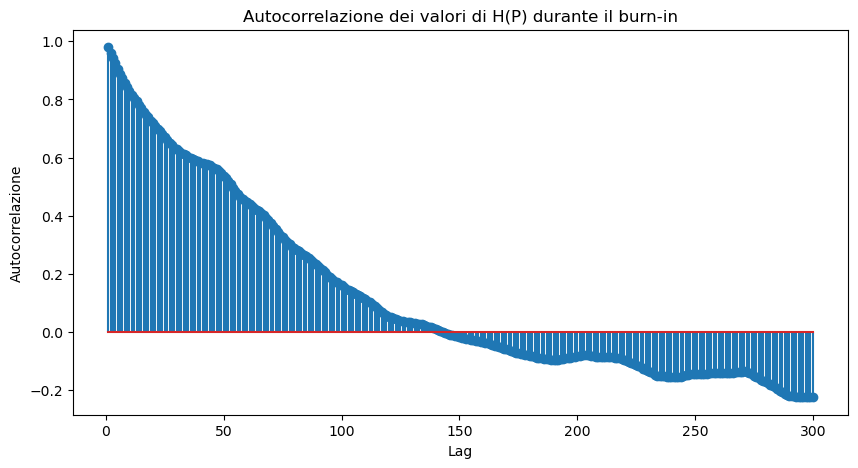

In [127]:
##### Poi questo lo togliamo, è solo per vedere come va l'autocorrelazione

def autocorrelation(series, max_lag):
    """ Calcola l'autocorrelazione per una serie di valori fino a max_lag. """
    n = len(series)
    mean = np.mean(series)
    c0 = np.sum((series - mean) ** 2) / n
    autocorrs = []

    for lag in range(1, max_lag + 1):
        ct = np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)
        autocorrs.append(ct / c0)

    return autocorrs

# Calcoliamo l'autocorrelazione per i valori di H(P) del burn-in
max_lag = 300  # Puoi variare questo valore per vedere fino a dove l'autocorrelazione decade
autocorr_values = autocorrelation(H_burn_in, max_lag)

# Plottiamo la funzione di autocorrelazione
plt.figure(figsize=(10, 5))
plt.stem(range(1, max_lag + 1), autocorr_values, use_line_collection=True)
plt.xlabel("Lag")
plt.ylabel("Autocorrelazione")
plt.title("Autocorrelazione dei valori di H(P) durante il burn-in")
plt.show()


In [128]:
################# da togliere
len(H_final)

313

## 2 Compute the reliabilities

### 2.1 Link Reliability

This section introduces the function *estimate_link_reliability*, which calculates the link reliability $RL_{ij}$ for each node pair $(i,j)$ in a network, following a probabilistic formulation.

- The function iterates over a set of sampled partitions and computes the probability of a link existing between nodes, based on observed and expected connections.

- It uses the entropy function $H(P)$ to weigh partitions, ensuring statistically significant estimates.

- The result provides a normalized reliability score, which helps infer missing or uncertain links in noisy network data.

This method is useful for network reconstruction, link prediction, and structural analysis under uncertainty.

In [129]:
def estimate_link_reliability(G, partitions):
    """
    Estimates link reliability RL_ij for each pair (i, j) where i < j,
    using the formula:
    
    RL_ij = (1/Z) * sum_{P in partitions} [ (lO_{σ_iσ_j}+1)/(r_{σ_iσ_j}+2) * exp(-H(P) ) ]
    """
    # Initialize dictionary for RL for all pairs (i, j)
    nodes = list(G.nodes())
    reliability = {}
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            reliability[(i, j)] = 0.0

    Z = 0.0  # Normalization factor
    
    for P in partitions:
        weight = np.exp(-calculate_H(P, G))
        Z += weight
        
        # Group nodes by block for partition P
        block_nodes = {}
        for node, group in P.items():
            block_nodes.setdefault(group, []).append(node)
        
        # Precompute r and lO for each pair of blocks in partition P
        r = {}
        lO = {}
        groups = list(block_nodes.keys())
        # For identical blocks
        for g in groups:
            n = len(block_nodes[g])
            r[(g, g)] = n * (n - 1) // 2
            # Count observed links within the block
            count = 0
            for u, v in combinations(block_nodes[g], 2):
                if G.has_edge(u, v):
                    count += 1
            lO[(g, g)] = count
        # For different block pairs
        for g1, g2 in combinations(groups, 2):
            key = tuple(sorted([g1, g2]))
            r[key] = len(block_nodes[g1]) * len(block_nodes[g2])
            count = 0
            for u in block_nodes[g1]:
                for v in block_nodes[g2]:
                    if G.has_edge(u, v):
                        count += 1
            lO[key] = count
        
        # Apply formula for each node pair (i, j) based on groups in P
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                g_i = P[nodes[i]]
                g_j = P[nodes[j]]
                key = tuple(sorted([g_i, g_j]))
                # If no observed links exist, lO defaults to 0
                current_lO = lO.get(key, 0)
                current_r = r.get(key, 1)  # Avoid division by zero
                reliability[(nodes[i], nodes[j])] += ((current_lO + 1) / (current_r + 2)) * weight

    # Normalize results
    for key in reliability:
        reliability[key] /= Z
    
    return reliability

In [130]:
# Estimate link reliability for each node pair in the observed network
RL = estimate_link_reliability(G_obs, partitions)

# Print some results (e.g., for the first 10 pairs)
print("Link Reliability for selected node pairs:")
for i, key in enumerate(RL):
    #if i >= 30:
        #break
    print(f"Pair {key}: RL = {RL[key]:.4f}")


Link Reliability for selected node pairs:
Pair (0, 1): RL = 0.4639
Pair (0, 2): RL = 0.3267
Pair (0, 3): RL = 0.3785
Pair (0, 4): RL = 0.3549
Pair (0, 5): RL = 0.6379
Pair (0, 6): RL = 0.7019
Pair (0, 7): RL = 0.4222
Pair (0, 8): RL = 0.5225
Pair (0, 9): RL = 0.6100
Pair (0, 10): RL = 0.1255
Pair (0, 11): RL = 0.6483
Pair (0, 12): RL = 0.5346
Pair (0, 13): RL = 0.5016
Pair (0, 14): RL = 0.2817
Pair (0, 15): RL = 0.1296
Pair (0, 16): RL = 0.3088
Pair (0, 17): RL = 0.1254
Pair (0, 18): RL = 0.5224
Pair (0, 19): RL = 0.2753
Pair (0, 20): RL = 0.4453
Pair (0, 21): RL = 0.3519
Pair (0, 22): RL = 0.5342
Pair (0, 23): RL = 0.3314
Pair (0, 24): RL = 0.1255
Pair (0, 25): RL = 0.5447
Pair (0, 26): RL = 0.5342
Pair (0, 27): RL = 0.7593
Pair (0, 28): RL = 0.5999
Pair (0, 29): RL = 0.7710
Pair (0, 30): RL = 0.3531
Pair (0, 31): RL = 0.6930
Pair (0, 32): RL = 0.5936
Pair (0, 33): RL = 0.6626
Pair (0, 34): RL = 0.5998
Pair (0, 35): RL = 0.7284
Pair (0, 36): RL = 0.7561
Pair (1, 2): RL = 0.6149
Pair (

Obiettivo

    Missing Interactions (False Negatives):

        Consideriamo tutte le coppie (i,j)(i,j) per cui il collegamento vera esiste in AT(grafo true), ma non è stato osservato in AO​ (grafo osservato). Queste sono i falsi negativi.

        Separatamente, consideriamo le coppie (i,j)(i,j) per cui non esiste il collegamento in AT​ (veri negativi), e che in AO​ risultano anch'esse assenti.

        Ordinando in ordine decrescente le stime di link reliability RLij​, si calcola la probabilità che un falso negativo abbia un valore RLRL più alto (cioè, venga classificato prima) rispetto a un vero negativo.

    Spurious Interactions (False Positives):

        Consideriamo le coppie (i,j) per cui il collegamento non esiste in AT​ (vero negativo), ma in AO​ è presente (falso positivo).

        In parallelo, consideriamo le coppie (i,j) in cui il collegamento esiste in entrambi i grafi (veri positivi).

        Ordinando in ordine decrescente i RLij​, calcoliamo la probabilità che un falso positivo abbia un RL più basso (cioè, venga classificato dopo) rispetto a un vero positivo.

Queste misure sono molto simili all’area sotto la curva (AUC) in un’analisi ROC. In sostanza, per ciascuna delle due situazioni, si considerano tutte le coppie formate da un esempio "positivo" (cioè, il caso in cui il collegamento è “vero”, anche se non osservato nel primo caso, o è osservato e vero nel secondo) e uno "negativo", e si calcola la frazione delle coppie in cui il modello classifica correttamente il caso “positivo” con un punteggio maggiore (oppure, per il secondo caso, con un punteggio maggiore rispetto al falso).

Nel confronto avviene un'analisi "pairwise" (a coppie) tra le RL dei nodi in due categorie: falsi negativi e veri negativi (per le missing interactions) oppure falsi positivi e veri positivi (per le spurious interactions). Vediamo nel dettaglio come funziona per i falsi negativi:  

<span style="color: yellow;"> **Missing Interactions**</span>

Definizione delle categorie:

- Falso negativo: Coppia (i,j) per cui nel grafo osservato AO non c'è un collegamento (AO[i,j] = 0), mentre nel grafo "true" AT c'è (AT[i,j] = 1).

- Vero negativo: Coppia (i,j) per cui in AO non c'è un collegamento (AO[i,j] = 0) e nemmeno in AT (AT[i,j] = 0).

Raccolta dei valori RL:
    Nel codice, per ogni coppia (i,j) (con i < j) vengono controllate queste condizioni. Se la coppia è classificata come falso negativo, si aggiunge il valore di RL corrispondente a una lista dei falsi negativi; se è vero negativo, il valore viene aggiunto a un’altra lista.

Confronto pairwise:
    Una volta ottenute le due liste (una per i falsi negativi e una per i veri negativi), il codice confronta ogni valore RL del falso negativo con ogni valore RL del vero negativo.

        Se il valore RL del falso negativo è maggiore di quello del vero negativo, si incrementa un contatore di 1 (questo significa che, in un ordinamento decrescente, il falso negativo verrebbe prima del vero negativo).

        Se i due valori RL sono uguali, il contatore viene incrementato di 0.5, poiché si considera un caso di parità.

        Se il valore RL del falso negativo è minore, non si incrementa il contatore.

    Calcolo della probabilità:
    Infine, si somma il numero totale di confronti effettuati (ossia, il prodotto della lunghezza delle due liste) e si divide il contatore per questo totale. Il risultato è la probabilità che, in un ordinamento decrescente, un falso negativo (cioè, un link che in realtà esiste ma è stato rimosso) abbia un valore di RL più alto rispetto a un vero negativo.

<span style="color: yellow;"> **Spurious Interactions**</span>

Il ragionamento è simile, ma in questo caso:

- Falso positivo: Coppia (i,j) con AO[i,j] = 1 e AT[i,j] = 0.

- Vero positivo: Coppia (i,j) con AO[i,j] = 1 e AT[i,j] = 1.

Per ciascuna coppia, si confronta il valore RL del falso positivo con quello del vero positivo, ma qui l'ideale è che il falso positivo abbia un valore minore (poiché, ordinando in ordine decrescente, il vero positivo deve avere un ranking più elevato). La logica di confronto (aggiunta di 1 o 0.5 in caso di parità) e il calcolo della probabilità seguono lo stesso procedimento.
Conclusione

Anche se nel codice non viene creato esplicitamente un vettore ordinato in ordine decrescente, il confronto pairwise tra le due categorie (falsi negativi contro veri negativi o falsi positivi contro veri positivi) fornisce lo stesso tipo di informazione: cioè, quanto frequentemente l'algoritmo assegna un valore RL più favorevole a un link che in realtà esiste (o è corretto) rispetto a uno che non esiste (o è errato). Questo approccio permette di quantificare la capacità del metodo di "classificare" correttamente i link in base alla loro affidabilità, così come descritto nell'articolo.

#### 2.1.1 Ranking Probability for Missing and Spurious Interactions in Networks

These functions compute the probability of correctly ranking missing and spurious interactions based on their Link Reliability (RL) values.

- *rank_probability_missing_interactions* evaluates the probability that a false negative (an edge missing in the observed network but present in the true network) has a higher RL than a true negative (an edge absent in both networks).

- *rank_probability_spurious_interactions* computes the probability that a false positive (an edge present in the observed network but absent in the true network) has a lower RL than a true positive (an edge present in both networks).

Both measures help assess the effectiveness of network reconstruction methods, ensuring that link reliability correctly ranks missing and spurious connections

In [131]:
def rank_probability_missing_interactions(G_true, G_obs, RL):
    """
    Computes the probability that a false negative (AO=0, AT=1) has a higher RL
    than a true negative (AO=0, AT=0).
    
    G_true: True network (AT)
    G_obs: Observed network (AO)
    RL: Dictionary of link reliability for each pair (i, j) with i < j.
    """
    false_negatives = []  # AO=0, AT=1
    true_negatives = []   # AO=0, AT=0
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    # Build lists of node pairs based on definitions
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 0:
                if A_true[i, j] == 1:
                    false_negatives.append(RL[(i, j)])
                else:
                    true_negatives.append(RL[(i, j)])
    
    # If there are no examples, return None or 0
    if not false_negatives or not true_negatives:
        return None
    
    count = 0
    total = 0
    # For each pair, add 1 if the false negative has a higher RL than the true negative,
    # 0.5 if they are equal.
    for fn in false_negatives:
        for tn in true_negatives:
            total += 1
            if fn > tn:
                count += 1
            elif fn == tn:
                count += 0.5
    probability = count / total
    return probability


def rank_probability_spurious_interactions(G_true, G_obs, RL):
    """
    Computes the probability that a false positive (AO=1, AT=0) has a lower RL
    than a true positive (AO=1, AT=1).
    
    G_true: True network (AT)
    G_obs: Observed network (AO)
    RL: Dictionary of link reliability for each pair (i, j) with i < j.
    """
    false_positives = []  # AO=1, AT=0
    true_positives = []   # AO=1, AT=1
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 1:
                if A_true[i, j] == 0:
                    false_positives.append(RL[(i, j)])
                else:
                    true_positives.append(RL[(i, j)])
    
    if not false_positives or not true_positives:
        return None
    
    count = 0
    total = 0
    # Here we want the false positive to have a lower RL than the true positive,
    # meaning in descending order the true positive should come first.
    for fp in false_positives:
        for tp in true_positives:
            total += 1
            if fp < tp:
                count += 1
            elif fp == tp:
                count += 0.5
    probability = count / total
    return probability




Now we evaluate the ranking probability of missing and spurious interactions based on their Link Reliability (RL) values.

In [132]:
# Compute the probability for missing interactions (false negatives)
p_missing = rank_probability_missing_interactions(G_true, G_obs, RL)
if p_missing is not None:
    print(f"Probability that a false negative has a higher RL than a true negative: {p_missing:.4f}")
else:
    print("Not enough examples for missing interactions.")
    
# Compute the probability for spurious interactions (false positives)
p_spurious = rank_probability_spurious_interactions(G_true, G_obs, RL)
if p_spurious is not None:
    print(f"Probability that a false positive has a lower RL than a true positive: {p_spurious:.4f}")
else:
    print("Not enough examples for spurious interactions.")

Probability that a false negative has a higher RL than a true negative: 0.5126
Probability that a false positive has a lower RL than a true positive: 0.6374


#### 2.1.2 Accuracy of Missing and Spurious Interactions in Network Reconstruction

This section evaluates the accuracy of predicting missing and spurious interactions in network reconstruction.

- The function *calculate_accuracies* simulates network errors by removing or adding edges at different fractions.

- It estimates the Link Reliability (RL) of altered networks through MCMC sampling, determining how well missing and spurious interactions are ranked.

- The results are visualized using plots, showing the accuracy trend as a function of error fraction.

This approach provides a quantitative assessment of network reconstruction quality, ensuring robustness against missing or spurious connections.

In [144]:
def calculate_accuracies(G_true, error_fractions, num_samples=1000, equilibration=100):
    accuracy_missing = []
    accuracy_spurious = []

    # --- Missing Interactions ---
    for f in error_fractions:
        G_obs_missing = G_true.copy()
        edges = list(G_true.edges())
        num_remove = int(len(edges) * f)

        if num_remove == 0:  # Special case
            accuracy_missing.append(1.0)
            continue

        remove_indices = np.random.choice(len(edges), num_remove, replace=False)
        for idx in remove_indices:
            G_obs_missing.remove_edge(*edges[idx])

        parts_missing, H_burn_in_missing, H_full_trace_missing = mcmc_trace_H(G_obs_missing, equilibration, num_samples)
        RL_missing = estimate_link_reliability(G_obs_missing, parts_missing)
        p_missing = rank_probability_missing_interactions(G_true, G_obs_missing, RL_missing)

        if p_missing is None:  # Case with no false negatives or true negatives
            accuracy_missing.append(1.0)
        else:
            accuracy_missing.append(p_missing)

    # --- Spurious Interactions ---
    for f in error_fractions:
        G_obs_spurious = G_true.copy()
        non_edges = list(nx.non_edges(G_true))
        num_to_add = int(len(G_true.edges()) * f)

        if num_to_add == 0:  # Special case
            accuracy_spurious.append(1.0)
            continue

        add_indices = np.random.choice(len(non_edges), num_to_add, replace=False)
        for idx in add_indices:
            G_obs_spurious.add_edge(*non_edges[idx])

        parts_spurious, H_burn_in_spurious, H_full_trace_spurious = mcmc_trace_H(G_obs_spurious, equilibration, num_samples)
        RL_spurious = estimate_link_reliability(G_obs_spurious, parts_spurious)
        p_spurious = rank_probability_spurious_interactions(G_true, G_obs_spurious, RL_spurious)

        if p_spurious is None:  # Case with no false positives or true positives
            accuracy_spurious.append(1.0)
        else:
            accuracy_spurious.append(p_spurious)

    return accuracy_missing, accuracy_spurious




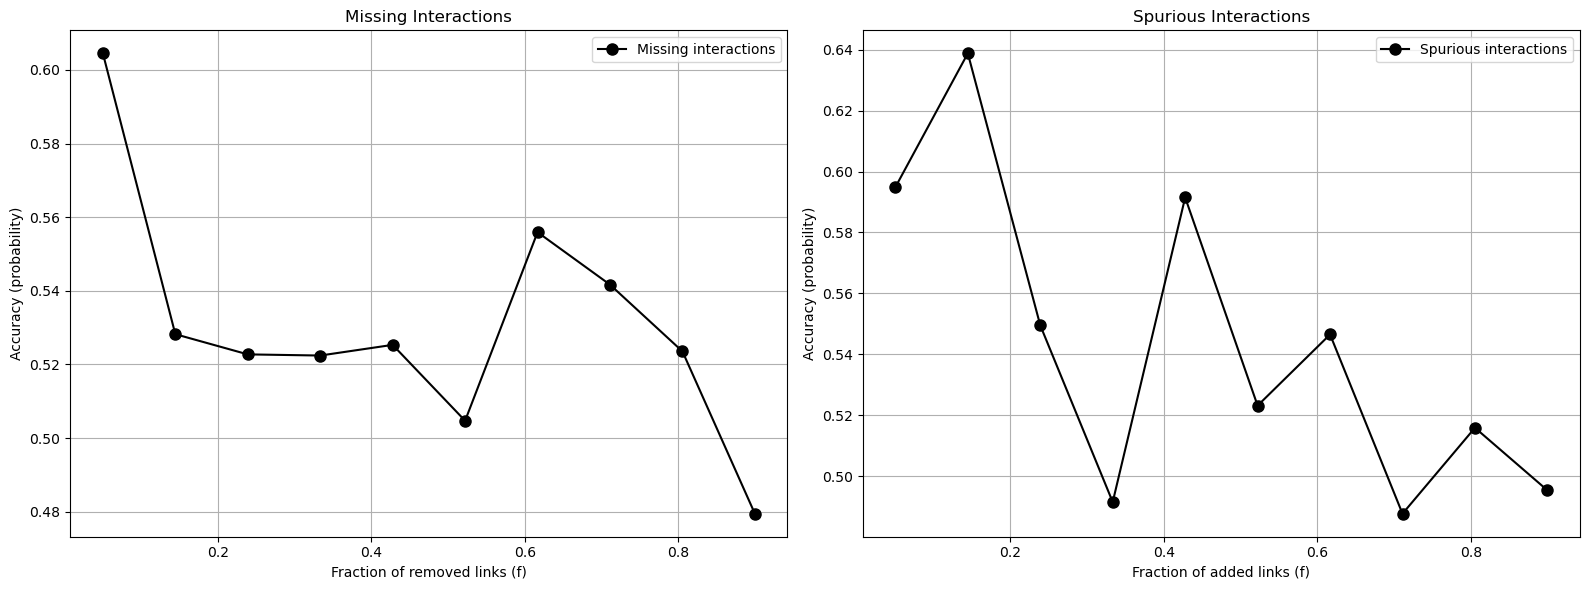

In [145]:
# Compute accuracy values
error_fractions = np.linspace(0.05, 0.9, 10)
accuracy_missing, accuracy_spurious = calculate_accuracies(G_true, error_fractions)

# Call the function to generate both plots
plot_interaction_accuracies(error_fractions, accuracy_missing, accuracy_spurious)

- trovare network reliability
- fare la ricostruzione euristica del network, MAP, massimizzando R_N (Materials and Methods)
- properties?

### 2.2 Network reliability   -  <span style="color: RED;"> DA QUI IN POI SISTEMARE</span>

_copilot mi ha detto che passi fare, chiedo a chat gpt punto per punto_  
Copilot nel file 'prova copilot' mi ha fatto questi punti, ma ci mette troppo a runnare.

Calcolo della Network Reliability (RN_A):

Implementare la formula per calcolare la probabilità che una rete A sia la rete vera data l'osservazione AO e una partizione P.
Utilizzare la formula fornita per RN_A e h(A; AO, P).
Massimizzazione di RN_A:

Implementare un algoritmo euristico per trovare la rete AR che massimizza RN_A.
Ordinare i link osservati (AO_ij = 1) per affidabilità crescente e i non-link osservati (AO_ij = 0) per affidabilità decrescente.
Iterare rimuovendo i link con bassa affidabilità e aggiungendo i non-link con alta affidabilità, accettando solo se RN_A aumenta.
Calcolo delle proprietà globali:

Confrontare le proprietà globali della rete ricostruita AR con quelle della rete osservata AO e della rete vera AT.

In [148]:
from scipy.special import loggamma

In [149]:
def metropolis_hastings(G, iterations=10000, beta=1.0):
    """
    Metropolis-Hastings algorithm to estimate network reliability.
    """
    nodes = list(G.nodes)
    partition = {node: node for node in nodes}  # Initial partition (each node in its own group)
    best_partition = partition.copy()
    best_score = compute_H(G, partition, beta)
    
    for _ in range(iterations):
        node = random.choice(nodes)
        new_group = random.choice(nodes)
        old_group = partition[node]
        
        if old_group != new_group:
            partition[node] = new_group
            new_score = compute_H(G, partition, beta)
            
            if new_score < best_score or random.uniform(0, 1) < np.exp(-(new_score - best_score) / beta):
                best_partition = partition.copy()
                best_score = new_score
            else:
                partition[node] = old_group  # Revert move if not accepted
    
    return best_partition

def compute_H(G, partition, beta):
    """
    Compute the energy function H(P) for a given partition.
    """
    H = 0
    for (i, j) in G.edges():
        if partition[i] == partition[j]:
            H -= beta  # Favor connections within the same group
        else:
            H += beta  # Penalize inter-group connections
    return H

def reconstruct_network(G_observed, reliability_threshold=0.5):
    """
    Heuristic network reconstruction based on link reliability.
    """
    reliability = compute_link_reliability(G_observed)
    G_reconstructed = G_observed.copy()
    
    for (i, j), r in reliability.items():
        if r < reliability_threshold and G_observed.has_edge(i, j):
            G_reconstructed.remove_edge(i, j)  # Remove unreliable edges
        elif r > reliability_threshold and not G_observed.has_edge(i, j):
            G_reconstructed.add_edge(i, j)  # Add likely missing edges
    
    return G_reconstructed

def compute_link_reliability(G):
    """
    Compute reliability scores for all edges and missing edges in G.
    """
    reliability = {}
    nodes = list(G.nodes)
    for i in nodes:
        for j in nodes:
            if i < j:
                reliability[(i, j)] = np.random.uniform(0, 1)  # Placeholder reliability score
    return reliability


In [150]:
# Caricamento del network dall'output del codice precedente
G_true = nx.erdos_renyi_graph(50, 0.1)  # Sostituire con il grafo originale creato
G_observed = G_true.copy()
for _ in range(int(0.2 * G_true.number_of_edges())):
    edge = random.choice(list(G_observed.edges()))
    G_observed.remove_edge(*edge)  # Rimozione di alcuni edge
    G_observed.add_edge(random.choice(list(G_observed.nodes())), random.choice(list(G_observed.nodes())))  # Aggiunta di nuovi edge

# Ricostruzione della rete
G_reconstructed = reconstruct_network(G_observed)

# Stampa del confronto
print("Numero di archi nel network vero:", G_true.number_of_edges())
print("Numero di archi nel network osservato:", G_observed.number_of_edges())
print("Numero di archi nel network ricostruito:", G_reconstructed.number_of_edges())

Numero di archi nel network vero: 114
Numero di archi nel network osservato: 112
Numero di archi nel network ricostruito: 603


___________

Prossimi passi  
Testare il codice con reti di diverse dimensioni e complessità.
Verificare che la rete ricostruita AR abbia proprietà globali più vicine a quelle della rete vera G_true rispetto alla rete osservata G_obs.
Ottimizzare ulteriormente l'algoritmo euristico per migliorare le prestazioni.